## **Controllable Generation using GANs with CelebA Dataset**

**Importing Libraries**

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import CelebA
from torchvision import transforms
import torchvision
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display
import os
import gdown
import zipfile
from google.colab import drive
import pandas as pd

In [2]:
epochs=10
z_dim=64
n_classes=40
image_resize=64
batch_size=128
lr=0.0002
betas=(0.5, 0.999)
device="cuda"
display_step=500

**Download the dataset manually, from the [official site](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)**, due to the error ``Google Drive - Quota exceeded``

**Direct Links:**
- [img_align_celeba.zip](https://drive.google.com/file/d/0B7EVK8r0v71pZjFTYXZWM3FlRnM/view?usp=sharing&resourcekey=0-dYn9z10tMJOBAkviAcfdyQ)
- [identity_CelebA.txt](https://drive.google.com/file/d/1_ee_0u7vcNLOfNLegJRHmolfH5ICW-XS/view?usp=sharing)
- [list_attr_celeba.txt](https://drive.google.com/file/d/0B7EVK8r0v71pblRyaVFSWGxPY0U/view?usp=sharing&resourcekey=0-YW2qIuRcWHy_1C2VaRGL3Q)
- [list_bbox_celeba.txt](https://drive.google.com/file/d/0B7EVK8r0v71pbThiMVRxWXZ4dU0/view?usp=sharing&resourcekey=0-z-17UMo1wt4moRL2lu9D8A)
- [list_landmarks_align_celeba.txt](https://drive.google.com/file/d/0B7EVK8r0v71pd0FJY3Blby1HUTQ/view?usp=sharing&resourcekey=0-aFtzLN5nfdhHXpAsgYA8_g)
- [list_landmarks_celeba.txt](https://drive.google.com/file/d/0B7EVK8r0v71pTzJIdlJWdHczRlU/view?usp=sharing&resourcekey=0-49BtYuqFDomi-1v0vNVwrQ)
- [list_eval_partition.txt](https://drive.google.com/file/d/0B7EVK8r0v71pY0NSMzRuSXJEVkk/view?usp=sharing&resourcekey=0-i4TGCi_51OtQ5K9FSp4EDg)

In [ ]:
# Direct links
root_directory = "/content/"
download_dir = os.path.join(root_directory, "celeba")

In [ ]:
os.mkdir(download_dir)

In [ ]:
dict_links = {
    "img_align_celeba.zip": "https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM",
    "identity_CelebA.txt": "https://drive.google.com/uc?id=1_ee_0u7vcNLOfNLegJRHmolfH5ICW-XS",
    "list_attr_celeba.txt": "https://drive.google.com/uc?id=0B7EVK8r0v71pblRyaVFSWGxPY0U",
    "list_bbox_celeba.txt": "https://drive.google.com/uc?id=0B7EVK8r0v71pbThiMVRxWXZ4dU0",
    "list_landmarks_align_celeba.txt": "https://drive.google.com/uc?id=0B7EVK8r0v71pd0FJY3Blby1HUTQ",
    "list_landmarks_celeba.txt": "https://drive.google.com/uc?id=0B7EVK8r0v71pTzJIdlJWdHczRlU",
    "list_eval_partition.txt": "https://drive.google.com/uc?id=0B7EVK8r0v71pY0NSMzRuSXJEVkk"
}

In [ ]:
for key, value in dict_links.items():
  gdown.download(value, os.path.join(download_dir, key))

In [ ]:
# Extracting: img_align_celeba.zip

zip_ref=zipfile.ZipFile(os.path.join(download_dir, list(dict_links.keys())[0]), "r")
zip_ref.extractall(download_dir)
zip_ref.close()

**Nota:** If you get the error:

```FileURLRetrievalError: Too many users have viewed or downloaded this file recently. Please try accessing the file again later. If the file you are trying to access is particularly large or is shared with many people, it may take up to 24 hours to be able to view or download the file. If you still can't access a file after 24 hours, contact your domain administrator.```

Generate a copy of the file that is ready in my [personal Google Drive](https://drive.google.com/drive/folders/1CTq1EKbv-hQlVJ-Df1k_oz3kNOiP1y1H?usp=drive_link) to your own Google Drive. Subsequently, connect with your Google Colab to mount your drive, or download the folder and upload it to the root directory of your work environment.

In [ ]:
# Mount drive from Google Colab
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Copy folder to root directory
!cp -r /content/drive/MyDrive/celeba /content/

In [ ]:
# Extracting: img_align_celeba.zip

zip_ref=zipfile.ZipFile(os.path.join(download_dir, list(dict_links.keys())[0]), "r")
zip_ref.extractall(download_dir)
zip_ref.close()

**Load Data**

In [ ]:
transform=transforms.Compose([
    transforms.Resize(image_resize),
    transforms.CenterCrop(image_resize),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_dataset=DataLoader(
    CelebA(root_directory, split="train", download=False, transform=transform),
    batch_size=batch_size,
    shuffle=True)

In [ ]:
for images, labels in train_dataset:
  print(images.shape, labels.shape)
  break

torch.Size([128, 3, 64, 64]) torch.Size([128, 40])


In [ ]:
labels[0]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1])

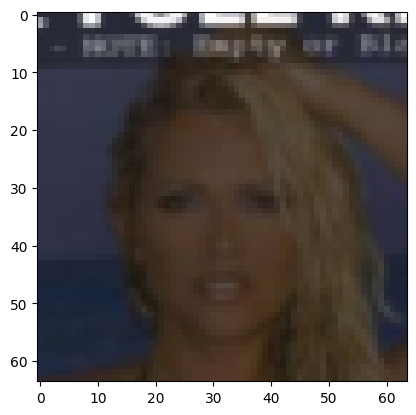

In [ ]:
plt.imshow((images[0].permute(1, 2, 0)+1)/2);

**Train the Classifier**

In [3]:
class Classifier(nn.Module):
  def __init__(self, im_channels=3, n_classes=n_classes, hidden_dim=64):
    super().__init__()

    self.classifier=nn.Sequential(
        nn.Conv2d(im_channels, hidden_dim, 4, 2, 1),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(hidden_dim, hidden_dim*2, 4, 2, 1),
        nn.BatchNorm2d(hidden_dim*2),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(hidden_dim*2, hidden_dim*4, 4, 2, 1),
        nn.BatchNorm2d(hidden_dim*4),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(hidden_dim*4, hidden_dim*8, 4, 2, 1),
        nn.BatchNorm2d(hidden_dim*8),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(hidden_dim*8, n_classes, 4, 1, 0),
        nn.Flatten()
    )

  def forward(self, image):
    return self.classifier(image)

In [ ]:
classifier=Classifier().to(device)
summary(classifier, (3, image_resize, image_resize))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,136
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,200
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,544
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,664
      BatchNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12             [-1, 40, 1, 1]         327,720
          Flatten-13                   [-1, 40]               0
Total params: 3,086,056
Trainable param

In [ ]:
class_optimizer=torch.optim.Adam(classifier.parameters(), lr=lr, betas=betas)
criterion=nn.BCEWithLogitsLoss()

In [ ]:
def show_metric(metric, name_metric="", color="blue"):

  #Graph smoothing
  step_bins=int(len(metric)*0.05)
  df=pd.DataFrame({f"{name_metric}": metric})
  rolling_mean=df[f"{name_metric}"].rolling(window=step_bins).mean()

  plt.figure(figsize=(10, 5))
  plt.plot(np.arange(1, len(metric)+1), rolling_mean.values, color=color)
  plt.title(f"{name_metric} Through Steps")
  plt.xlabel("Step")
  plt.ylabel(f"{name_metric}")
  plt.show()

In [ ]:
def train_classifier(epochs=epochs, display_wait=False):

  classifier_losses=[]
  classifier_accuracy=[]
  step=1

  for epoch in range(epochs):
    with tqdm(train_dataset) as pbar:
      pbar.set_description(f"[Epoch: {epoch+1}/{epochs}]")
      for images, labels in pbar:
        cur_batch_size=len(images)

        images=images.to(device)
        labels=labels.to(device).to(torch.float32)

        # Update classifier
        class_optimizer.zero_grad()
        labels_pred=classifier(images)

        class_loss=criterion(labels_pred, labels)
        class_loss.backward()
        class_optimizer.step()

        classifier_losses.append(class_loss.item())

        labels_pred_sig=torch.sigmoid(labels_pred.detach())
        labels_pred_sig=(labels_pred_sig>=0.5).float()
        class_accuracy=(labels==labels_pred_sig).float().mean()
        classifier_accuracy.append(class_accuracy.item())

        #Visualization
        pbar.set_postfix({"Step": step, "class_loss": class_loss.item(), "class_acc": class_accuracy.item()})

        if step%display_step==0:
          display.clear_output(wait=display_wait)

          show_metric(classifier_losses, name_metric="Loss")
          show_metric(classifier_accuracy, name_metric="Accuracy", color="red")

        step+=1

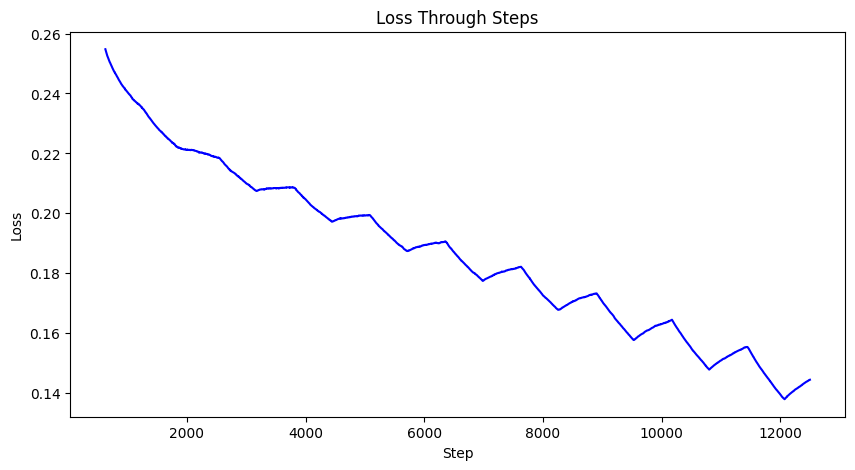

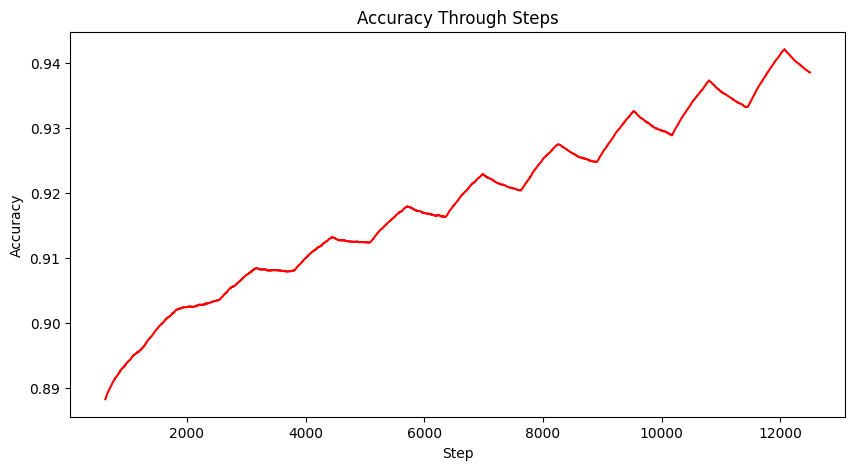

[Epoch: 10/10]: 100%|██████████| 1272/1272 [04:53<00:00,  4.33it/s, Step=12720, class_loss=0.158, class_acc=0.932]


In [ ]:
train_classifier()

In [ ]:
!mkdir /content/models/

In [ ]:
# Save the model

torch.save(classifier.state_dict(), "/content/models/model_classifier.pth")

**Train the Generator**

In [4]:
class Generator(nn.Module):
  def __init__(self, z_dim=z_dim, im_channels=3, hidden_dim=64):
    super().__init__()

    self.generator=nn.Sequential(
        nn.ConvTranspose2d(z_dim, hidden_dim*8, 4, 1, 0, bias=False),
        nn.BatchNorm2d(hidden_dim*8),
        nn.ReLU(True),

        nn.ConvTranspose2d(hidden_dim*8, hidden_dim*4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(hidden_dim*4),
        nn.ReLU(True),

        nn.ConvTranspose2d(hidden_dim*4, hidden_dim*2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(hidden_dim*2),
        nn.ReLU(True),

        nn.ConvTranspose2d(hidden_dim*2, hidden_dim, 4, 2, 1, bias=False),
        nn.BatchNorm2d(hidden_dim),
        nn.ReLU(True),

        nn.ConvTranspose2d(hidden_dim, im_channels, 4, 2, 1, bias=False),
        nn.Tanh()
    )

  def forward(self, noise):
    return self.generator(noise)

In [ ]:
generator=Generator().to(device)
summary(generator, (z_dim, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         524,288
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

In [5]:
class Discriminator(nn.Module):
  def __init__(self, im_channels=3, n_classes=n_classes, hidden_dim=64):
    super().__init__()

    self.discriminator=nn.Sequential(
        nn.Conv2d(im_channels, hidden_dim, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(hidden_dim, hidden_dim*2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(hidden_dim*2),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(hidden_dim*2, hidden_dim*4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(hidden_dim*4),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(hidden_dim*4, hidden_dim*8, 4, 2, 1, bias=False),
        nn.BatchNorm2d(hidden_dim*8),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(hidden_dim*8, n_classes, 4, 1, 0, bias=False),
        nn.Sigmoid()
    )

  def forward(self, image):
    return self.discriminator(image)

In [ ]:
discriminator=Discriminator(n_classes=1).to(device)
summary(discriminator, (3, image_resize, image_resize))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,072
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,288
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12              [-1, 1, 1, 1]           8,192
          Sigmoid-13              [-1, 1, 1, 1]               0
Total params: 2,765,568
Trainable param

In [ ]:
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find("Conv") != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find("BatchNorm") != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

generator=generator.apply(weights_init)
discriminator=discriminator.apply(weights_init)

In [ ]:
gen_optimizer=torch.optim.Adam(generator.parameters(), lr=lr, betas=betas)
disc_optimizer=torch.optim.Adam(discriminator.parameters(), lr=lr, betas=betas)
criterion=nn.BCELoss()

In [ ]:
def show_images(real_images, fake_images, num_images=25, nrow=5, cmap="gray"):

  real_images=real_images.cpu()
  fake_images=fake_images.cpu()

  # Denormalization
  real_images=(real_images+1)/2 #[0., 1.]
  fake_images=(fake_images+1)/2 #[0., 1.]

  real_images=make_grid(real_images[:num_images], nrow=nrow).permute(1, 2, 0)
  fake_images=make_grid(fake_images[:num_images], nrow=nrow).permute(1, 2, 0)

  fig, ax = plt.subplots(1, 2, figsize=(nrow*2, nrow*2))
  ax[0].imshow(fake_images, cmap=cmap)
  ax[0].axis("off")
  ax[0].set_title("Generated Images")

  ax[1].imshow(real_images, cmap=cmap)
  ax[1].axis("off")
  ax[1].set_title("Real Images")

  plt.show()

def show_losses(generator_losses, discriminator_losses):
  step_bins=int(len(generator_losses)*0.05)
  df=pd.DataFrame({"Generator Loss": generator_losses, "Discriminator Loss":discriminator_losses})
  rolling_mean_gen=df["Generator Loss"].rolling(window=step_bins).mean()
  rolling_mean_disc=df["Discriminator Loss"].rolling(window=step_bins).mean()

  plt.figure(figsize=(10, 5))
  plt.plot(np.arange(1, len(generator_losses)+1), rolling_mean_gen, label="Generator Loss")
  plt.plot(np.arange(1, len(generator_losses)+1), rolling_mean_disc, label="Discriminator Loss")
  plt.title("Losses Through Steps")
  plt.xlabel("Step")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

In [ ]:
def train_gan(epochs=epochs, display_wait=False):

  generator_losses=[]
  discriminator_losses=[]
  step=1

  for epoch in range(epochs):
    with tqdm(train_dataset) as pbar:
      pbar.set_description(f"[Epoch: {epoch+1}/{epochs}]")
      for real_images, _ in pbar:
        cur_batch_size=len(real_images)
        real_images=real_images.to(device)

        # Update discriminator
        disc_optimizer.zero_grad()
        noise=torch.randn(cur_batch_size, z_dim, 1, 1, device=device)
        fake_images=generator(noise).detach()
        fake_out=discriminator(fake_images)
        fake_loss=criterion(fake_out, torch.zeros_like(fake_out))

        real_out=discriminator(real_images)
        real_loss=criterion(real_out, torch.ones_like(real_out))

        disc_loss=(fake_loss+real_loss)/2
        disc_loss.backward(retain_graph=True)
        disc_optimizer.step()

        discriminator_losses.append(disc_loss.item())

        # Update Generator
        gen_optimizer.zero_grad()
        noise=torch.randn(cur_batch_size, z_dim, 1, 1, device=device)
        fake_images=generator(noise)
        fake_out=discriminator(fake_images)
        gen_loss=criterion(fake_out, torch.ones_like(fake_out))

        gen_loss.backward(retain_graph=True)
        gen_optimizer.step()

        generator_losses.append(gen_loss.item())

        #Visualization
        pbar.set_postfix({"Step": step, "gen_loss": gen_loss.item(), "disc_loss": disc_loss.item()})

        if step%display_step==0:
          display.clear_output(wait=display_wait)
          noise=torch.randn(cur_batch_size, z_dim, 1, 1, device=device)
          fake_images=generator(noise).detach()

          show_images(real_images, fake_images)
          show_losses(generator_losses, discriminator_losses)

        step+=1

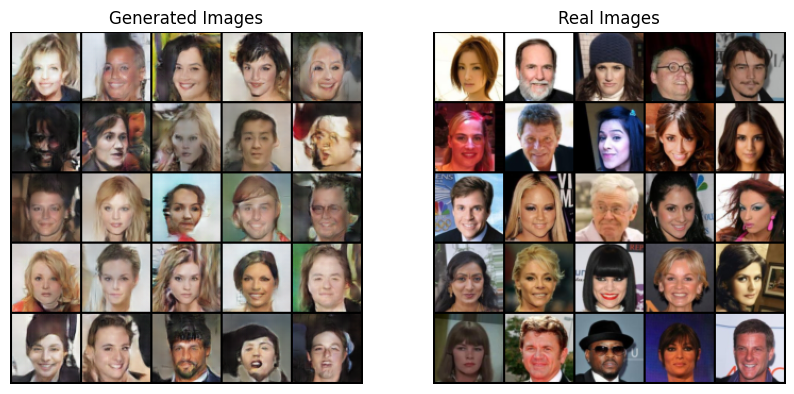

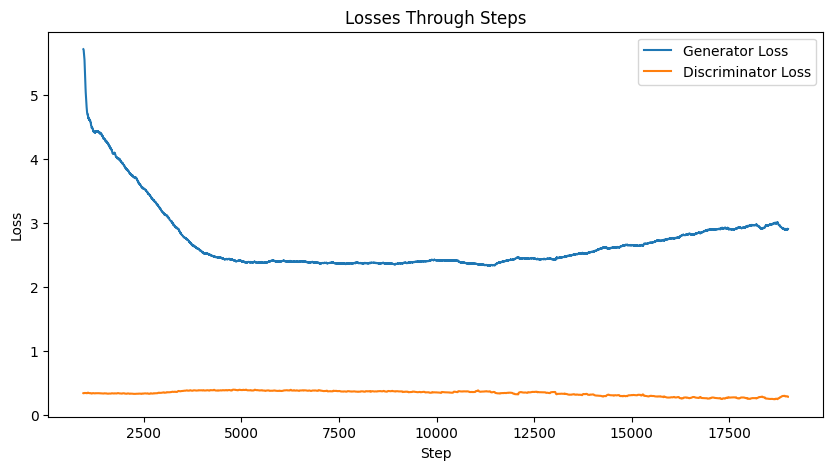

[Epoch: 15/15]: 100%|██████████| 1272/1272 [07:15<00:00,  2.92it/s, Step=19080, gen_loss=2.88, disc_loss=0.0884]


In [ ]:
train_gan(epochs=15)

In [ ]:
!mkdir /content/models/

In [ ]:
# Save the model

torch.save(generator.state_dict(), "/content/models/model_generator.pth")

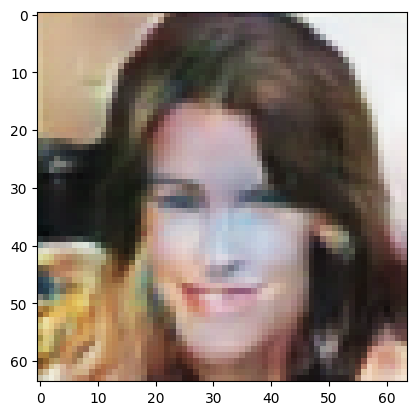

In [ ]:
# Example

noise=torch.randn(1, z_dim, 1, 1, device=device)
fake_images=generator(noise).detach().cpu()
fake_images=(fake_images+1)/2
plt.imshow(fake_images.squeeze().permute(1, 2, 0));

#### **Controllable Generation**

Load training models

In [40]:
classifier=Classifier().to(device)
classifier.load_state_dict(torch.load("/content/models/model_classifier.pth"))
classifier.eval()

Classifier(
  (classifier): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 40, kernel_size=(4, 4), stride=(1, 1))
    (12): Flatten(start_dim=1, end_dim=-1)
  )
)

In [41]:
generator=Generator().to(device)
generator.load_state_dict(torch.load("/content/models/model_generator.pth"))
generator.eval()

Generator(
  (generator): Sequential(
    (0): ConvTranspose2d(64, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  

In [42]:
class_optimizer=torch.optim.Adam(classifier.parameters(), lr=lr, betas=betas)

In [43]:
feature_names=["5oClockShadow", "ArchedEyebrows", "Attractive", "BagsUnderEyes", "Bald", "Bangs",
"BigLips", "BigNose", "BlackHair", "BlondHair", "Blurry", "BrownHair", "BushyEyebrows", "Chubby",
"DoubleChin", "Eyeglasses", "Goatee", "GrayHair", "HeavyMakeup", "HighCheekbones", "Male",
"MouthSlightlyOpen", "Mustache", "NarrowEyes", "NoBeard", "OvalFace", "PaleSkin", "PointyNose",
"RecedingHairline", "RosyCheeks", "Sideburn", "Smiling", "StraightHair", "WavyHair", "WearingEarrings",
"WearingHat", "WearingLipstick", "WearingNecklace", "WearingNecktie", "Young"]

In [ ]:
num_images=8
grad_steps=10
skip=2

In [44]:
#Function for stochastic gradient ascent
def calculate_updated_noise(noise, weight):
  new_noise=noise+noise.grad*weight
  return new_noise

def show_tensor_images(image_tensor, num_images, size=(3, 64, 64), nrow=3):
  image_tensor=(image_tensor+1)/2
  image_unflat=image_tensor.detach().cpu()
  image_grid=make_grid(image_unflat[:num_images], nrow=nrow)

  plt.figure(figsize=(int(num_images*1.5), int(grad_steps/skip *1.5)))
  plt.imshow(image_grid.permute(1, 2, 0))
  plt.axis("off")
  plt.show()

In [46]:
def show_cont_generation(feature="Smiling", num_images=num_images, grad_steps=grad_steps, skpi=skip):
  fake_images_history=[]
  target_indices=feature_names.index(feature)
  noise=torch.randn(num_images, z_dim, 1, 1, device=device).requires_grad_()

  for i in range(grad_steps):
    class_optimizer.zero_grad()
    fake_image=generator(noise)
    fake_images_history.append(fake_image)
    fake_classes_score=classifier(fake_image)[:, target_indices].mean()
    fake_classes_score.backward()
    noise.data=calculate_updated_noise(noise, 1/grad_steps)

  show_tensor_images(torch.cat(fake_images_history[::skip], dim=2), num_images=num_images, nrow=num_images)

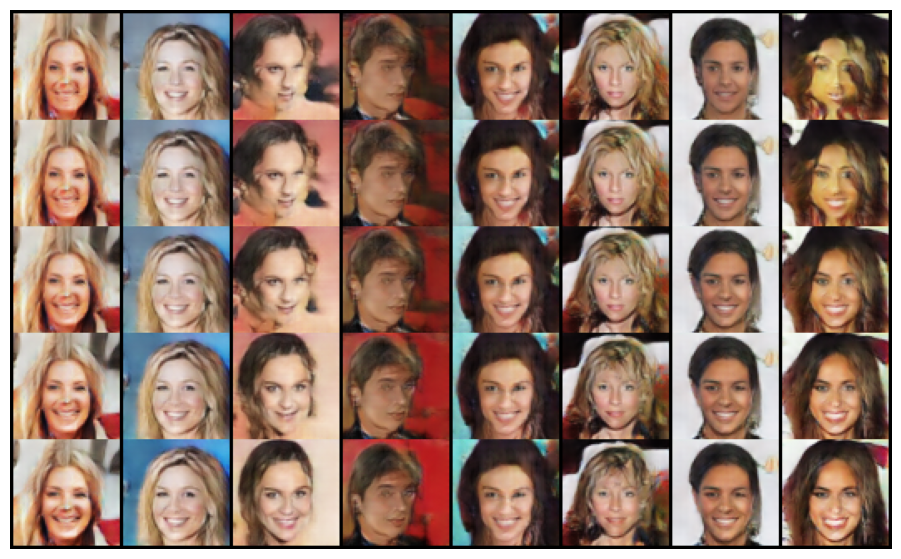

In [ ]:
show_cont_generation()

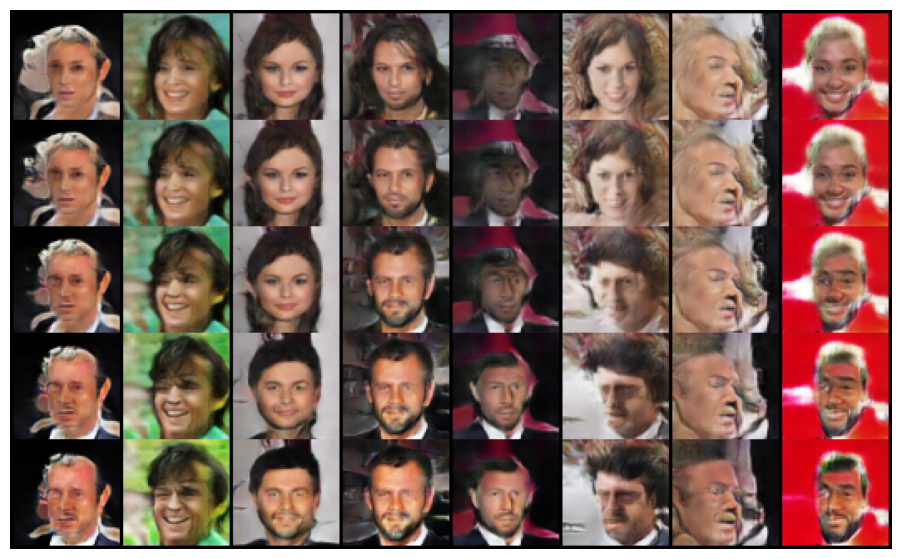

In [ ]:
show_cont_generation("Male")

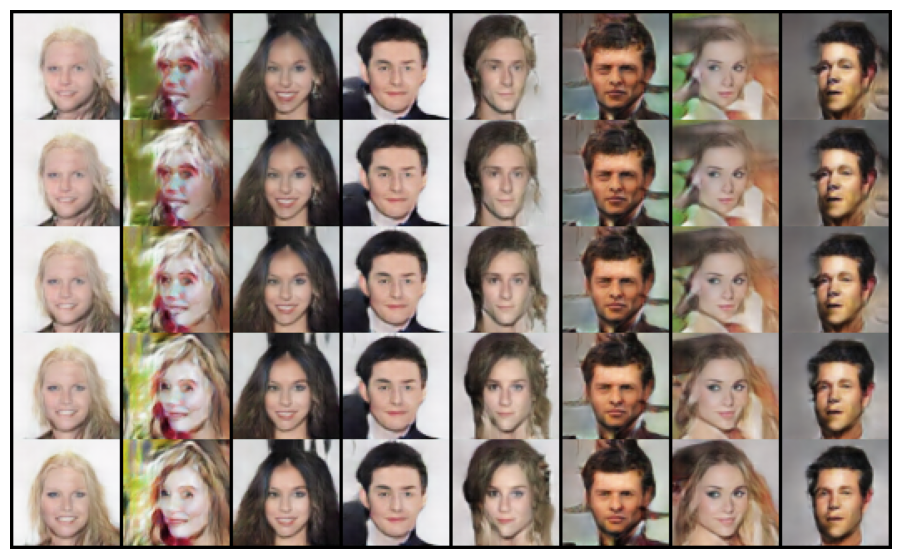

In [ ]:
show_cont_generation("Attractive")

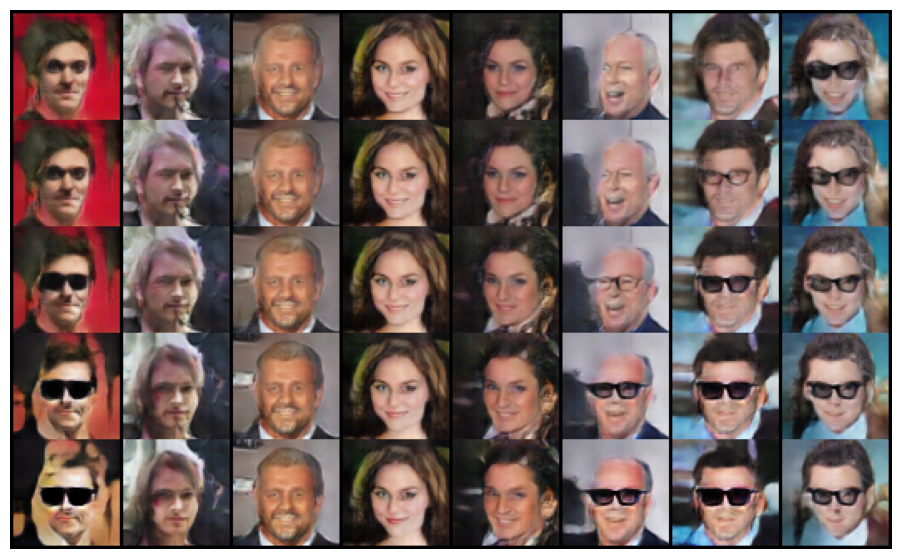

In [ ]:
show_cont_generation("Eyeglasses")

Entanglement and Regularization

In [54]:
def get_score(current_classifications, original_classifications, target_indices, other_indices, penalty_weight):
  other_distances = current_classifications[:, other_indices] - original_classifications[:, other_indices]
  other_class_penalty = -torch.mean(torch.norm(other_distances, dim=1)) * penalty_weight
  target_score = torch.mean(current_classifications[:, target_indices])
  return target_score + other_class_penalty

In [57]:
class_optimizer=torch.optim.Adam(classifier.parameters(), lr=lr, betas=betas)

In [55]:
num_images=8
grad_steps=10
skip=2

In [59]:
def show_entang_regularization(feature="Smiling"):
  fake_images_history=[]
  target_indices=feature_names.index(feature)
  other_indices=[cur_idx!=target_indices for cur_idx, _ in enumerate(feature_names)]
  noise=torch.randn(num_images, z_dim, 1, 1, device=device).requires_grad_()
  original_classifications=classifier(generator(noise)).detach()

  for i in range(grad_steps):
    class_optimizer.zero_grad()
    fake_image=generator(noise)
    fake_images_history += [fake_image]
    fake_score = get_score(
        classifier(fake_image),
        original_classifications,
        target_indices,
        other_indices,
        penalty_weight=0.1
    )
    fake_score.backward()
    noise.data=calculate_updated_noise(noise, 1 / grad_steps)

  show_tensor_images(torch.cat(fake_images_history[::skip], dim=2), num_images=num_images, nrow=num_images)

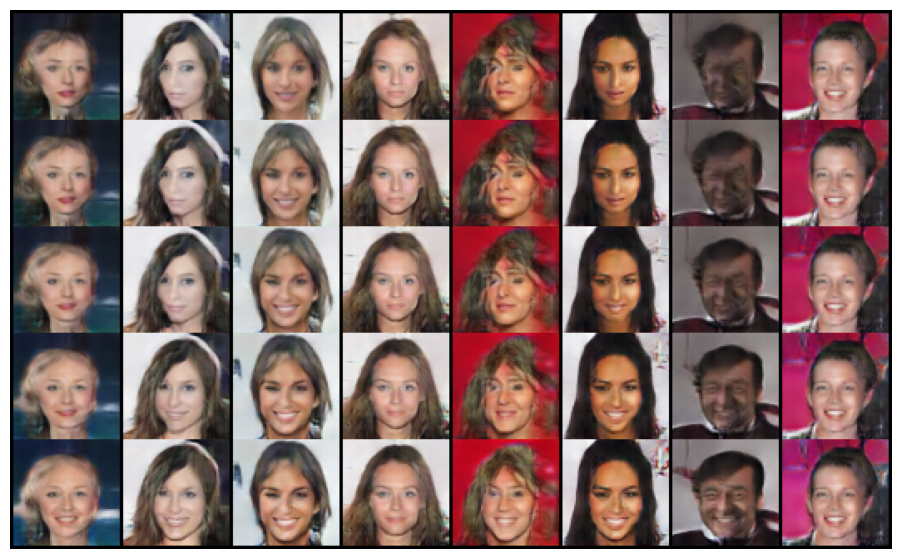

In [66]:
show_entang_regularization()

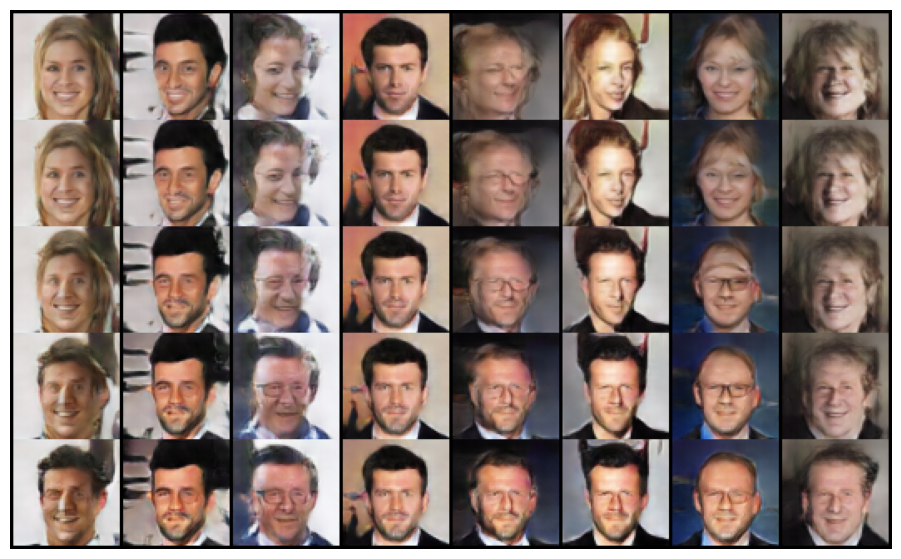

In [76]:
show_entang_regularization("Male")

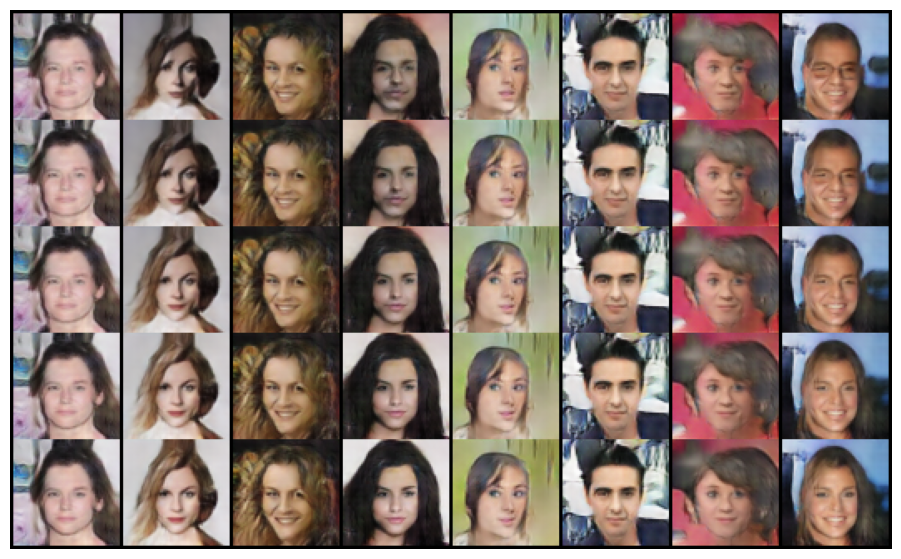

In [81]:
show_entang_regularization("Attractive")

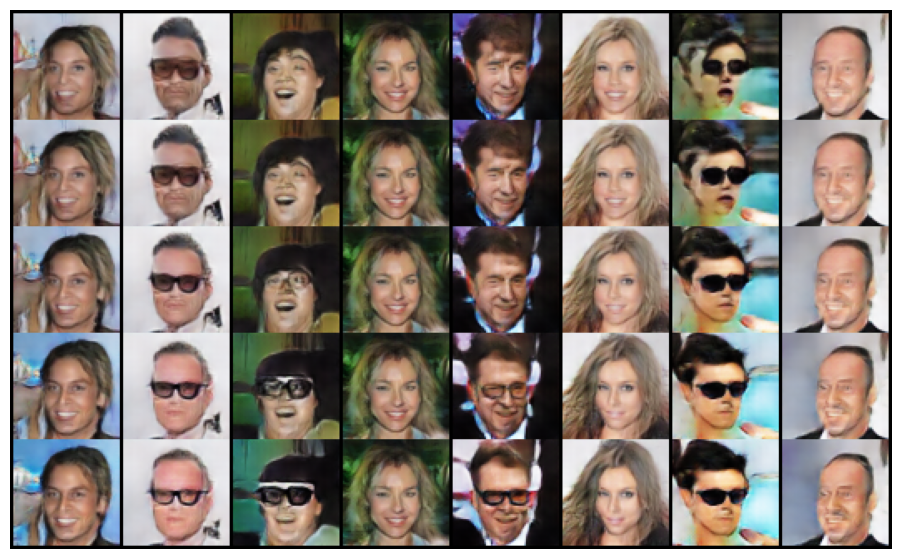

In [83]:
show_cont_generation("Eyeglasses")